## gpu-rsi demonstration
This notebook uses the PyGpuRSI wrapper class defined in the
PyGpuRaySurfaceIntersect module to execute the CUDA code that
checks for line-segment and surface-triangle intersection.

In [1]:
__copyright__ = "Copyright (c) 2022, Raymond Leung"
__license__   = "BSD-3-clause"

In [2]:
import numpy as np
import os, shutil, sys
from input_synthesis import synthesize_data
from gpu_ray_surface_intersect import PyGpuRSI

In [3]:
GPU_CODE_DIR = os.getcwd().replace('scripts', '')
WORK_DIR = os.getcwd().replace('scripts', 'scratch')
DATA_DIR = os.path.join(WORK_DIR, 'input')
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
os.chdir(WORK_DIR)

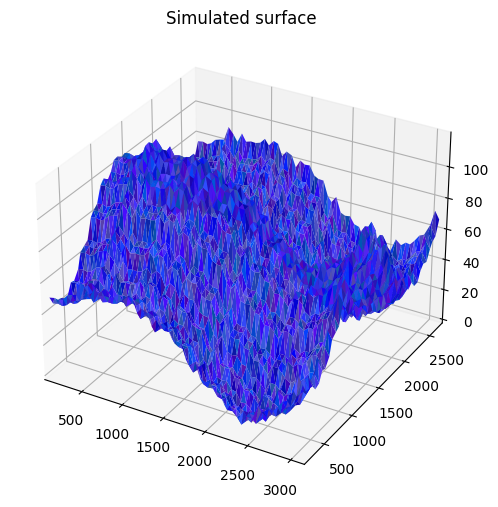

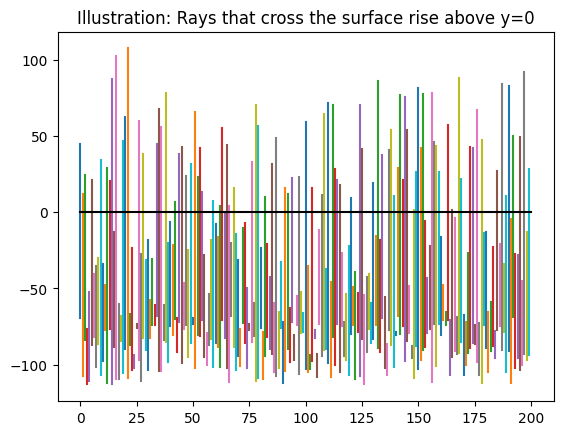

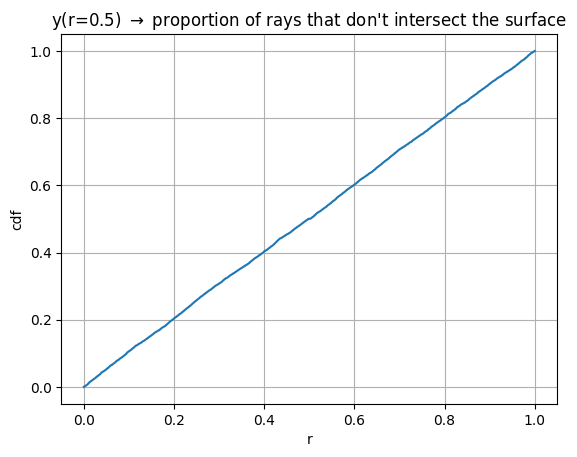

Essential files written in 0.0005896091461181641s
Saving ground-truth...


In [4]:
# Synthesize the input data
synthesize_data(DATA_DIR, n_triangles_approx=5000, n_rays=10000,
                show_graphics=True, save_results_in_binary=True)

In [5]:
# This step is not needed in standard workflow since (vertices, triangles, rayFrom,
# rayTo) would normally exist as numpy arrays. Here, we read these from files instead.
def bin2array(filename, precision, dims=2):
    with open(filename, 'rb') as f:
        data = np.fromfile(f, dtype=precision)
    return data.reshape([int(len(data)/3), 3]) if dims==2 else data

vertices = bin2array('input/vertices_f32', np.float32)
triangles = bin2array('input/triangles_i32', np.int32)
rayFrom = bin2array('input/rayFrom_f32', np.float32)
rayTo = bin2array('input/rayTo_f32', np.float32)

#### (Part A) Run CUDA program in "boolean" mode to return 0/1 intersection results

#### GPU ray-segment surface intersection tests are applied in two ways

In [6]:
# Approach 1:
rsi = PyGpuRSI(GPU_CODE_DIR, WORK_DIR, cfg={"nvcc_compile": "nvcc"})
# - compile CUDA code the first time
# - subsequently, doesn't compile if GPU_BIN_TARGET already exists

results = rsi.test(vertices, triangles, rayFrom, rayTo)
# - The WORK_DIR contains source code and binary at this point
# - You may run .test again using another surface by specifying
#   new vertices and triangles, with both rayFrom and rayTo
#   omitted, which means you will reuse the same line segments.

compiling CUDA code...
nvcc compilation succeeded!
/home/wangl/repos/gpu-ray-surface-intersection-in-cuda/scratch/input/vertices_f32 contains 29160 bytes, 7290 <f>, 2430 elements
/home/wangl/repos/gpu-ray-surface-intersection-in-cuda/scratch/input/triangles_i32 contains 55968 bytes, 13992 <i>, 4664 elements
/home/wangl/repos/gpu-ray-surface-intersection-in-cuda/scratch/input/rayFrom_f32 contains 120000 bytes, 30000 <f>, 10000 elements
/home/wangl/repos/gpu-ray-surface-intersection-in-cuda/scratch/input/rayTo_f32 contains 120000 bytes, 30000 <f>, 10000 elements
1024 threads/block, grids: {triangles: 5, rays: 16}
[0, 2996.48] delta: 0.00142884
[0, 2498.01] delta: 0.00119114
[0, 119.385] delta: 5.69271e-05
checking sortMortonCode
0: (319) 591192771007738224
1: (318) 591249970458744472
2: (320) 591289779898227861
3: (321) 591467403494521149
4: (322) 591536140177348605
5: (323) 591625908859955321
6: (424) 591663521518223038
7: (425) 591694178063391814
8: (426) 591703065887014071
9: (428) 59

In [7]:
#- user is responsible for clean-up when work is finished
rsi.cleanup()

#- check if binary still exists
gpu_bin_target = 'gpu_ray_surface_intersect.exe'
if os.path.isfile(gpu_bin_target):
    print(f'{gpu_bin_target} still exists')
else:
    print(f'{gpu_bin_target} has been removed')

cleaning up...
gpu_ray_surface_intersect.exe has been removed


In [8]:
# Approach 2: using with statement (auto clean-up)
# The `quiet` flag (optional) suppresses console output
with PyGpuRSI(GPU_CODE_DIR, WORK_DIR, quiet=True) as rsi:
    results2 = rsi.test(vertices, triangles, rayFrom, rayTo)

compiling CUDA code...
nvcc compilation succeeded!
cleaning up...


In [9]:
all(results == results2)

True

#### (Part B) Run CUDA program in "barycentric" mode to return the distance to surface, intersecting triangle and intersecting point for each intersecting ray. 

In [10]:
from input_synthesis import synthesize_data

fw = lambda x: os.path.join('ínput', x)
geom_info = {}

synthesize_data(outdir=DATA_DIR, n_triangles_approx=5000, n_rays=10000,
                show_graphics=False, save_results_in_binary=True,
                perturb_centroid=True, feedback=geom_info)
print('Created {}'.format(geom_info))
vertices = bin2array('input/vertices_f32', np.float32)
triangles = bin2array('input/triangles_i32', np.int32)
rayFrom = bin2array('input/rayFrom_f32', np.float32)
rayTo = bin2array('input/rayTo_f32', np.float32)

Essential files written in 0.0005815029144287109s
Saving ground-truth...
Created {'nVertices': 2430, 'nTriangles': 4664, 'nRays': 10000}


In [11]:
# Configuration
# Set operating mode to 'barycentric' to return
# - intersecting rays
# - distance from the starting point of the ray to the surface
# - intersecting triangle
# - intersecting point
parms = {'mode':'barycentric', 'keep_cuda_binary': True}

In [12]:
# GPU ray-segment surface intersection tests are invoked below
rsi = PyGpuRSI(GPU_CODE_DIR, WORK_DIR, cfg=parms)

intersecting_rays, distances, hit_triangles, hit_points = \
      rsi.test(vertices, triangles, rayFrom, rayTo)

compiling CUDA code...
nvcc compilation succeeded!
/home/wangl/repos/gpu-ray-surface-intersection-in-cuda/scratch/input/vertices_f32 contains 29160 bytes, 7290 <f>, 2430 elements
/home/wangl/repos/gpu-ray-surface-intersection-in-cuda/scratch/input/triangles_i32 contains 55968 bytes, 13992 <i>, 4664 elements
/home/wangl/repos/gpu-ray-surface-intersection-in-cuda/scratch/input/rayFrom_f32 contains 120000 bytes, 30000 <f>, 10000 elements
/home/wangl/repos/gpu-ray-surface-intersection-in-cuda/scratch/input/rayTo_f32 contains 120000 bytes, 30000 <f>, 10000 elements
1024 threads/block, grids: {triangles: 5, rays: 16}
[0, 2996.48] delta: 0.00142884
[0, 2498.01] delta: 0.00119114
[0, 119.385] delta: 5.69271e-05
checking sortMortonCode
0: (319) 591192771007738224
1: (318) 591249970458744472
2: (320) 591289779898227861
3: (321) 591467403494521149
4: (322) 591536140177348605
5: (323) 591625908859955321
6: (424) 591663521518223038
7: (425) 591694178063391814
8: (426) 591703065887014071
9: (428) 59

In [13]:
# Compare results with ground truth
gt_hit_points = bin2array('input/intercepts', np.float32)
gt_hit_triangles = bin2array('input/intersect_triangle', np.int32, dims=1)
gt_intersecting_rays = gtidx = np.where(gt_hit_triangles >= 0)[0]
gt_hit_points = gt_hit_points[gtidx]
gt_hit_triangles = gt_hit_triangles[gtidx]
gt_distances = np.sqrt(np.sum((gt_hit_points - rayFrom[gtidx])**2, axis=1))

In [14]:
import pandas as pd
print('Running GPU code in barycentric output mode\n')
print('Ray-surface intersections: detected:{} (actual:{})'.format(len(intersecting_rays), len(gt_intersecting_rays)))
print('Undetected rays (FN): {}'.format(np.setdiff1d(gt_intersecting_rays, intersecting_rays)))
print('False detections (FP): {}'.format(np.setdiff1d(intersecting_rays, gt_intersecting_rays)))

df1 = pd.DataFrame(np.c_[hit_triangles, hit_points, distances],
                   columns=['triangle','px','py','pz','dist'],
                   index=intersecting_rays)
df2 = pd.DataFrame(np.c_[gt_hit_triangles, gt_hit_points, gt_distances],
                   columns=['gt_triangle','gt_px','gt_py','gt_pz','gt_dist'],
                   index=intersecting_rays)
dfc = pd.merge(df1, df2, left_index=True, right_index=True)

n_same = sum(dfc['triangle']==dfc['gt_triangle'])
print('Intersecting triangles: {}/{} ({}%) identical'.format(
       n_same, len(dfc), (100.*n_same)/len(dfc)))

p1 = dfc[['px','py','pz']].values
p2 = dfc[['gt_px','gt_py','gt_pz']].values
pc = np.abs(np.sqrt(np.sum((p2 - p1)**2, axis=1))) < 0.001
print('Intersecting points:    {}/{} ({}%) equivalent'.format(
       sum(pc), len(pc), (100.*sum(pc))/len(pc)))

dc = np.isclose(dfc['dist'], dfc['gt_dist'])
print('Computed intersecting distances: {}/{} ({}%) equivalent'.format(
       sum(dc), len(dc), (100.*sum(dc))/len(dc)))

Running GPU code in barycentric output mode

Ray-surface intersections: detected:4996 (actual:4996)
Undetected rays (FN): []
False detections (FP): []
Intersecting triangles: 4996/4996 (100.0%) identical
Intersecting points:    4996/4996 (100.0%) equivalent
Computed intersecting distances: 4996/4996 (100.0%) equivalent


In [15]:
#- check out some values
dfc.iloc[:8]

,triangle,px,py,pz,dist,gt_triangle,gt_px,gt_py,gt_pz,gt_dist
0,936.0,2516.387695,466.657410,25.994621,69.554527,936.0,2516.387695,466.657410,25.994616,69.554520
1,4411.0,1842.089722,2365.756104,41.435928,107.649765,4411.0,1842.089844,2365.756104,41.435951,107.649780
2,3820.0,132.782318,2052.052734,45.840248,84.017975,3820.0,132.782318,2052.052734,45.840252,84.017982
5,3585.0,2473.858154,1898.664185,17.536171,87.018379,3585.0,2473.857910,1898.664185,17.536173,87.018394
9,1907.0,2975.301025,1001.311096,93.062691,107.074615,1907.0,2975.301025,1001.311096,93.062675,107.074608
12,1534.0,1439.519531,812.136169,87.718971,112.286987,1534.0,1439.519531,812.136169,87.718971,112.286980
13,3392.0,19.109852,1827.365845,55.489624,76.898331,3392.0,19.109852,1827.365845,55.489628,76.898331
14,234.0,634.218384,126.535545,55.207100,112.502609,234.0,634.218384,126.535538,55.207108,112.502609


In [16]:
rsi.cleanup()

cleaning up...
